[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/SciML/blob/main/SciML.ipynb)

# Scientific machine learning

## Introduction
Scientific machine learning (SciML) combines methodologies from **machine learning** and **scientific computing** to develop models that are both **data-driven** and **domain-aware**.

SciML aims to leverage the **flexibility** of machine learning methods while retaining the **interpretability** of scientific models by incorporating physical constraints or other domain knowledge.

This tutorial compares two fundamental classes of SciML problems: **Neural Ordinary/Partial Differential Equations (ODEs/PDEs)** and **Physics-Informed Neural Networks (PINNs)**. The schematic below illustrates the basic conceptual differences between these two classes of problems.

![schematic](schematic.png)

We will make use of the [`PyTorch`](https://pytorch.org/) deep learning library to train machine learning models and perform **automatic differentiation** (essential for PINNs), and the [`torchdiffeq`](https://github.com/rtqichen/torchdiffeq) library of ODE solvers (implemented in `PyTorch`) to perform **numerical integration** (essential for neural ODEs).

### References
**Neural ODEs/PDEs**
- [Chen, Ricky TQ, et al. "Neural ordinary differential equations." *Advances in neural information processing systems* 31 (2018).](https://arxiv.org/pdf/1806.07366.pdf)
- [Rackauckas, Christopher, et al. "Universal differential equations for scientific machine learning." *arXiv preprint arXiv:2001.04385* (2020).](https://arxiv.org/pdf/2001.04385.pdf)

**PINNs**
- [Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." *Journal of Computational physics* 378 (2019): 686-707.](https://www.sciencedirect.com/science/article/pii/S0021999118307125)

## Getting started
### If running within Google Colaboratory:
1. Go to Runtime > Change runtime type, and select GPU.
2. Clone the GitHub repository to access the tutorial files:

In [ ]:
!git clone https://github.com/ninarina12/SciML.git
%cd SciML

Install additional packages:

In [ ]:
!pip install torchdiffeq
!pip install cmcrameri

### Import all necessary packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint, odeint_adjoint
from utils import (get_batch, format_axis, props, cmap, animate_node_history, animate_pinn_history,
                   node_inference, pinn_inference)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

## Part I: Neural Differential Equations

Neural differential equations are neural network models which approximate an unknown ODE or PDE from a set of observations of the solution at discrete time points. For example, consider the ODE,

$$\frac{dy}{dt} \approx f_{\theta}(t,y),$$

where $f_{\theta}$ is a neural network with trainable weights $\theta$ that takes $t$ and $y$ as inputs and outputs an approximation for $dy/dt$.

The neural network weights are trained by minimizing a loss function, such as the mean squared error (MSE), between the true solutions $y_k$, observed at discrete time points $t_k$, and the predicted $\hat{y}_k$ obtained by numerically solving the neural ODE. The typical workflow is as follows:

1. Numerically integrate the neural ODE from a given initial condition $y_0$,

$$\hat{y}(t)=y_0 + \int_0^{t}f_\theta(\tau,y)d\tau.$$

2. Compute the loss function between the observed and predicted solutions at the observed time points $t_k$,

$$\mathcal{L} = \frac{1}{N}\sum_{k=1}^N(y_k - \hat{y}_k)^2.$$

3. Backpropagate\* and update the neural network weights using a chosen optimizer.

\*Note that backpropagation through the integral can be memory intensive and/or numerically unstable for some solvers.  For this reason, the adjoint method (implemented in `torchdiffeq`) can be used to compute the necessary gradients (more details in the original [paper](https://arxiv.org/pdf/1806.07366.pdf)). For more in-depth study, I highly recommend these [course notes](https://book.sciml.ai/), which also include a detailed derivation of the [adjoint for an ODE](https://book.sciml.ai/notes/11-Differentiable_Programming_and_Neural_Differential_Equations/).

### ODE Basics

Start by writing a general `ODE` class which can be used to define both true and neural differential equations. The method `solve` uses `odeint` or `odeint_adjoint` to numerically integrate the ODE at times `t` starting from an initial condition `y0`.

In [2]:
class ODE(nn.Module):  
    def __init__(self, method='dopri5', adjoint=False, requires_grad=True, default_type=torch.float64):      
        super(ODE, self).__init__()
        
        self.method = method
        self.adjoint = adjoint if requires_grad else False
        self.odeint = odeint_adjoint if self.adjoint else odeint
        self.default_type = default_type
        
    
    def solve(self, t, y0, device='cpu', rtol=1e-7, atol=1e-9):
        if self.training:
            return self.odeint(self.to(device), y0.to(device), t.to(device), method=self.method,
                               rtol=rtol, atol=atol, options={'dtype':self.default_type})
        else:
            with torch.no_grad():
                return odeint(self.to(device), y0.to(device), t.to(device), method=self.method,
                              rtol=rtol, atol=atol, options={'dtype':self.default_type})

### Example ODE

For this tutorial, we're going to train a neural network to model the [Fisher-Kolmogorov–Petrovsky–Piskunov](https://en.wikipedia.org/wiki/Fisher%27s_equation) (Fisher-KPP) PDE of a reaction diffusion system,

$$\frac{d\rho}{dt} = r\rho(1-\rho) + D\frac{d^2\rho}{dx^2},$$

where $r$ and $D$ are the reaction and diffusion constants, respectively.

First, we will generate training data by numerically solving the true Fisher-KPP equation with periodic boundary conditions from a set of initial conditions of the form,

$$\rho_0(x) = a\exp{\left(-\frac{x - b}{2c^2}\right)}.$$

We can discretize the PDE over a spatial grid using finite differences, converting it to a system of ODEs:

$$\frac{d\rho_j}{dt} = r\rho_j(1-\rho_j) + D\frac{\rho_{j+1} - 2\rho_j + \rho_{j-1}}{h^2},$$

where $h = L/N$ denotes the spacing for a system of length $L$ discretized into a grid of size $N$. This can then be numerically integrated in time using an ODE solver. Here we've specified the Dormand-Prince method (`dopri5`) as implemented in `torchdiffeq` as the default solver.

In [3]:
class FisherKPP(ODE):
    def __init__(self, args, method='dopri5', default_type=torch.float64):
        super(FisherKPP, self).__init__(method, adjoint=False, requires_grad=False, default_type=default_type)
        
        default_args = {'N': 20,
                        'L': 1,
                        'r': 0.5,
                        'D': 1e-3
                       }
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        # Reaction term
        self.f = lambda y: self.r*y*(1 - y)
        
        # Diffusion term
        self.h = self.L/self.N
        kernel = (1./self.h)**2*torch.tensor([[[1,-2,1]]], dtype=default_type)
        self.conv = nn.Conv1d(1, 1, kernel.shape[-1], bias=False, padding='same', padding_mode='circular')
        self.conv.weight = nn.Parameter(self.D*kernel, requires_grad=False)

        self.eval()
        
            
    def init_state(self, M=1, args={}, seed=4):
        # Generate initial condition(s)
        torch.manual_seed(seed) 
        x = torch.arange(0, self.L, self.h)
        
        default_args = {'a': 0.2,
                        'b': torch.rand(size=(M,1,1)),
                        'c': 2*self.h
                       }
        for k, v in default_args.items():
            if k not in args.keys():
                args[k] = v
        
        return args['a']*(torch.exp(-0.5*(x - self.L*args['b'])**2/args['c']**2))
        
        
    def forward(self, t, y):
        return self.f(y) + self.conv(y)

Numerically integrate the ODE for a specific choice of parameters $N,L,r$ and $D$ and evaluate at evenly-spaced time points $t_k$ between $0$ and $t_f$. In this example, we generate $M$ different initial conditions with $N$ evenly-spaced values of $x$ between $0$ and $L$, setting $a=0.2$ and $c=2h$ and randomly sampling $b$ between $0$ and $L$.

In [4]:
args = {'N': 20,
        'L': 1,
        'r': 0.5,
        'D': 1e-3
       }
M = 100

ode = FisherKPP(args, method='dopri5', default_type=default_type).to(device)
y0 = ode.init_state(M)

tf = 10
dt = 0.1
t = torch.arange(0, tf, dt)
y = ode.solve(t, y0, device=device)

Plot the true solution of the $i^{th}$ initial condition.

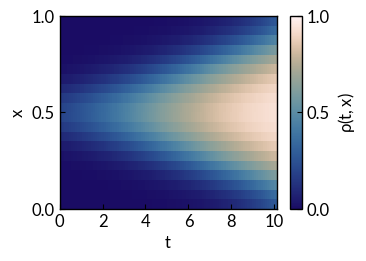

In [5]:
i = 0
fig, ax = plt.subplots(figsize=(3.5,2.5))
sm = ax.imshow(y[:,i].squeeze().cpu().T, aspect='auto', interpolation='nearest', extent=(0,tf+dt,0,ode.L),
               cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
format_axis(ax, props, 't', 'x', xbins=6, ybins=3)
cbar = plt.colorbar(sm, ax=ax, aspect=16)
format_axis(cbar.ax, props, ylabel=r'$\rho(t,x)$', ybins=3)

### Neural ODE

Suppose now that the exact form of the Fisher-KPP equation is unknown; instead, we will model it as a sum of neural networks that approximate the reaction and diffusion terms,

$$\frac{d\rho}{dt} \approx f_\theta(\rho) + g_\phi(\rho),$$

where $f_\theta(\rho)$ is a simple feed-forward neural network modeling the reaction term, and $g_\phi(\rho)$ is a convolutional neural network modeling the diffusion term. $\theta$ and $\phi$ denote the trainable parameters of each model, respectively. In this example, $f_\theta(\rho)$ is specified by the number of neurons in the hidden layer, `hidden_dim`, while $g_\phi(\rho)$ is specified by the size of the convolutional kernel, `kernel_size`.

In [6]:
class NeuralODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NeuralODE, self).__init__(method, adjoint, requires_grad=True, default_type=default_type)
        
        default_args = {'hidden_dim': 10,
                        'kernel_size': 3,
                       }
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        # Reaction term
        self.f = nn.Sequential(
            nn.Linear(1, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, 1)
        )
        
        # Diffusion term
        self.conv = nn.Conv1d(1, 1, self.kernel_size, bias=False, padding='same', padding_mode='circular')
        
        
    def forward(self, t, y):
        return self.f(y[...,None]).view(y.shape) + self.conv(y)

In [7]:
args = {'hidden_dim': 10,
        'kernel_size': 3
       }

node = NeuralODE(args, method='dopri5', adjoint=False, default_type=default_type).to(device)
optimizer = optim.Adam(node.parameters(), lr=1e-3)
model_path = 'fkpp_node.torch'
print(node)

NeuralODE(
  (f): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=same, bias=False, padding_mode=circular)
)


### Training

To train our model, we will also specify the following parameters:
- `max_iters` - Maximum number of iterations, *i.e.* how many batches of training data the model will see
- `batch_time` - Number of time steps to sample in one training batch
- `batch_size` - Number of initial conditions to sample in one training batch
- `chkpt` - Number of iterations after which to record the current output

At each checkpoint, we will record the loss, make a prediction of the current solution from a single initial condition, and record the current equation learned by the neural ODE. This will allow us to keep track of how the model is training. In the end, we can visualize the training history, which should look something like this:
![fkpp_node_history](fkpp_node_history.gif)

In [8]:
max_iters = 1000
batch_time = 5
batch_size = 10

try: saved = torch.load(model_path)
except:
    chkpt = 100
    loss = []
    
    t_eval = torch.arange(0, tf, dt)
    y_true = ode.solve(t_eval, y0[[0]], device).squeeze().cpu()
    y_pred = []
    
    dx = ode.L/ode.N
    y_eval = torch.arange(0, ode.L + dx, dx)
    f_true = ode(torch.tensor(0), y_eval[:,None,None].to(device)).squeeze().cpu()
    f_pred = []
else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    
    t_eval = saved['t_eval']
    y_true = saved['y_true']
    y_pred = saved['y_pred']
    
    y_eval = saved['y_eval']
    f_true = saved['f_true']
    f_pred = saved['f_pred']
    
    node.load_state_dict(saved['state'])
    node.to(device)
    optimizer.load_state_dict(saved['optimizer'])

The training loop below can be run as many times as desired until the loss is sufficiently low or makes no further improvement.

In [ ]:
end = time.time()
for k in range(1, max_iters + 1):
    node.train()
    optimizer.zero_grad()
  
    t_batch, y0_batch, y_batch = get_batch(t, y0, y, batch_time, batch_size)
    y_pred_batch = node.solve(t_batch, y0_batch, device)
    _loss = nn.MSELoss()(y_pred_batch, y_batch)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.2e} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))
        
            node.eval()
            y_pred.append(node.solve(t_eval, y0[[0]], device).squeeze().cpu())
            f_pred.append(node(torch.tensor(0), y_eval[:,None,None].to(device)).squeeze().cpu())
        
    end = time.time()

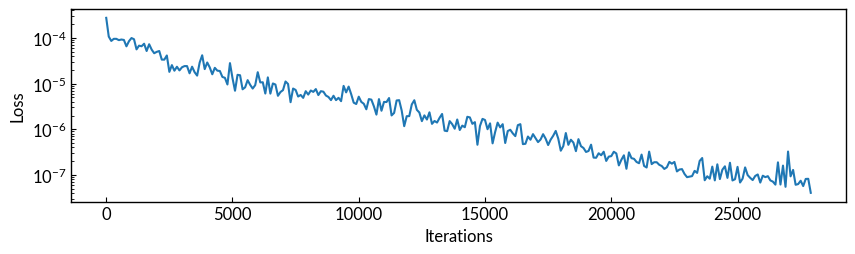

In [9]:
fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot([chkpt*k for k in range(len(loss))], loss)
ax.set_yscale('log')
format_axis(ax, props, 'Iterations', 'Loss')

In [ ]:
torch.save({
    'state': node.state_dict(),
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss,
    't_eval': t_eval,
    'y_true': y_true,
    'y_pred': y_pred,
    'y_eval': y_eval,
    'f_true': f_true,
    'f_pred': f_pred,
}, model_path)

In [ ]:
# Save an animation of the training history
ani = animate_node_history(model_path)
ani.save('fkpp_node_history.gif')

### Inference

Now that we have a trained neural ODE, we can evaluate it on different initial conditions or go beyond the time points seen during training to see how it extrapolates beyond the training data.

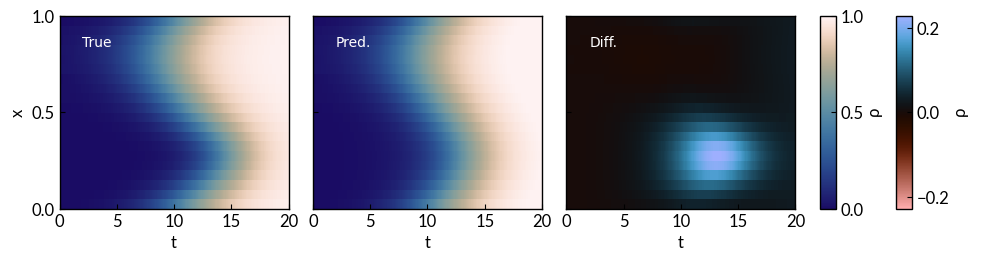

In [10]:
m = 4
y0_inf = ode.init_state(m, {'a': 0.1*torch.rand(m,1,1), 'b': torch.rand(m,1,1), 'c': 0.1*torch.rand(m,1,1)})
y0_inf = y0_inf.mean(dim=0, keepdim=True)
t_inf = torch.arange(0, 2*tf, dt)

fig = node_inference(ode, node, t_inf, y0_inf, device)

## Part II: Physics-Informed Neural Networks

Physics-informed neural networks are neural network models which approximate the solution of a known ODE or PDE that is typically difficult or computationally-expensive to integrate numerically. For example, let's consider the Fisher-KPP PDE of the previous section,

$$\frac{d\rho}{dt} = r\rho(1-\rho) + D\frac{d^2\rho}{dx^2}.$$

We can hypothesize that the solution $\rho(t,x)$ to a specific initial/boundary value problem can be modeled by a neural network $f_\theta$, parameterized by trainable weights $\theta$,

$$\rho(t,x) \approx f_\theta(t,x).$$

If this were true, then the neural network would be expected to satisfy the PDE of the system; that is,

$$\frac{df_\theta}{dt} = rf_\theta(1-f_\theta) + D\frac{d^2f_\theta}{dx^2}.$$

The neural network weights are thereby trainable by minimizing a loss function, such as the MSE, between the left- and right-hand sides of the equation above for a set of randomly sampled $\{t_k, x_k\}$ in the domain,

$$\mathcal{L}_{PDE} = \frac{1}{N}\sum_{k=1}^N\left[\frac{df_\theta}{dt}\bigg|_{t_k,x_k} - \left(rf_\theta(1-f_\theta) + D\frac{d^2f_\theta}{dx^2}\right)\bigg|_{t_k,x_k}\right]^2.$$

Additionally, since the solution corresponds to a specific choice of initial and boundary conditions, these should also be used to constrain the neural network. For instance, for the initial condition $\rho_0(x)$ and periodic boundary conditions,

$$\mathcal{L}_{IC} = \frac{1}{N_I}\sum_{k=1}^{N_I}\left(\rho_0(x_k) - f_\theta(0,x_k)\right)^2,$$

where $N_I$ is the number of points $x_k$ sampled at the initial time, and

$$\mathcal{L}_{BC} = \frac{1}{N_B}\sum_{k=1}^{N_B}\left(f_\theta(t_k,0) - f_\theta(t_k,L)\right)^2,$$

where $N_B$ is the number of points $t_k$ sampled at the boundaries. The total loss used to optimize the neural network is then given by,

$$\mathcal{L} = \mathcal{L}_{PDE} + \mathcal{L}_{IC} + \mathcal{L}_{BC}.$$

### Example PINN

Let's implement a simple feed-forward neural network to model the solution to the Fisher-KPP equation with periodic boundary conditions under a specific choice of initial condition.

The neural network is specified by the number of neurons in the hidden layers, `hidden_dim`, and the number of layers, `num_layers`.

The initial condition is specified by the parameters $a,b$ and $c$. Here, we select $a=0.2, b=0.5$, and $c=0.1$.

Finally, we use automatic differentiation to compute the derivatives of $f_\theta$ with respect to the inputs $t$ and $x$. The method `pde` below outputs the calculated left- and right-hand sides of the PDE using the current state of the network.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, args, default_type=torch.float64):   
        super(NeuralNetwork, self).__init__()
        
        default_args = {'r': 0.5,
                        'D': 1e-3,
                        'hidden_dim': 16,
                        'num_layers': 8
                       }
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        modules = [nn.Sequential(
                   nn.Linear(2, self.hidden_dim),
                   nn.Tanh(),
            )] 
        for i in range(1, self.num_layers - 1):
            modules.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.Tanh(),
            ))     
        modules.append(nn.Linear(self.hidden_dim, 1))
        
        self.f = nn.Sequential(*modules)
    
    
    def init_state(self, x, args={}):
        # Generate initial condition
        default_args = {'a': 0.2,
                        'b': 0.5,
                        'c': 0.1
                       }
        for k, v in default_args.items():
            if k not in args.keys():
                args[k] = v
                
        return args['a']*(torch.exp(-0.5*(x - args['b'])**2/args['c']**2))
    
        
    def pde(self, t, x):
        # Calculate PDE
        y = self(t, x)
        y_x = torch.autograd.grad(y, x, create_graph=True, grad_outputs=torch.ones_like(y))[0]
        y_xx = torch.autograd.grad(y_x, x, create_graph=True, grad_outputs=torch.ones_like(y))[0]
        y_t = torch.autograd.grad(y, t, create_graph=True, grad_outputs=torch.ones_like(y))[0]
        return y_t, self.r*y*(1 - y) + self.D*y_xx


    def forward(self, t, x):
        z = torch.cat([t, x], dim=-1)
        return self.f(z)

In [12]:
args = {'r': 0.5,
        'D': 1e-3,
        'hidden_dim': 32,
        'num_layers': 8
       }

pinn = NeuralNetwork(args, default_type).to(device)
optimizer = optim.Adam(pinn.parameters(), lr=3e-4)
model_path = 'fkpp_pinn.torch'

### Training

To train our model, we will also specify the following parameters:
- `max_iters` - Maximum number of iterations, *i.e.* how many batches of training data the model will see
- `batch_size` - Number of interior points to sample in one training batch
- `chkpt` - Number of iterations after which to record the current output

At each checkpoint, we will record the loss, make a prediction of the current solution, and record the current discrepancy in the PDE. This will allow us to keep track of how the model is training. In the end, we can visualize the training history, which should look something like this:
![fkpp_pinn_history](fkpp_pinn_history.gif)

In [13]:
N = 20
L = 1.
tf = 10
dt = 0.1
t = torch.arange(0, tf, dt)[:,None].to(device)
x = torch.arange(0, L, L/N)[:,None].to(device)

# Initial state
t0 = torch.zeros_like(x)
y0 = pinn.init_state(x).to(device)

# Boundaries
xr = torch.zeros_like(t)
xl = L*torch.ones_like(t)

max_iters = 1000
batch_size = 1000

try: saved = torch.load(model_path)
except:
    chkpt = 100
    loss = []
    
    t_eval, x_eval = torch.meshgrid((t.squeeze(), x.squeeze()), indexing='xy')
    t_eval, x_eval = t_eval.reshape(-1,1), x_eval.reshape(-1,1)
    t_eval.requires_grad = True
    x_eval.requires_grad = True
    y_true = ode.solve(t.squeeze(), y0.T[None,:], device).squeeze().cpu().T
    y_pred = []
    f_pred = []
else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    
    t_eval = saved['t_eval'].to(device)
    x_eval = saved['x_eval'].to(device)
    y_true = saved['y_true']
    y_pred = saved['y_pred']
    f_pred = saved['f_pred']
    
    t_eval.requires_grad = True
    x_eval.requires_grad = True
    pinn.load_state_dict(saved['state'])
    pinn.to(device)
    optimizer.load_state_dict(saved['optimizer'])

The training loop below can be run as many times as desired until the loss is sufficiently low or makes no further improvement.

In [ ]:
end = time.time()
for k in range(1, max_iters + 1):
    pinn.train()
    optimizer.zero_grad()
    
    # Initial condition loss
    y0_pred = pinn(t0, x)
    loss_ic = nn.MSELoss()(y0_pred, y0)
    
    # Boundary condition loss
    yr_pred = pinn(t, xr)
    yl_pred = pinn(t, xl)
    loss_bc = nn.MSELoss()(yr_pred, yl_pred)
    
    # PDE loss
    t_batch = tf*torch.rand((batch_size,1), requires_grad=True, device=device)
    x_batch = L*torch.rand((batch_size,1), requires_grad=True, device=device)
    loss_pde = nn.MSELoss()(*pinn.pde(t_batch, x_batch))
    
    # Total loss
    _loss = loss_ic + loss_bc + loss_pde
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.2e} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))
        
            pinn.eval()
            y_pred.append(pinn(t_eval, x_eval).reshape(len(x),len(t)).squeeze().cpu())
        
        y_lhs, y_rhs = pinn.pde(t_eval, x_eval)
        y_lhs = y_lhs.reshape(len(x),len(t)).squeeze().detach().cpu()
        y_rhs = y_rhs.reshape(len(x),len(t)).squeeze().detach().cpu()
        f_pred.append(y_lhs - y_rhs)
            
    end = time.time()

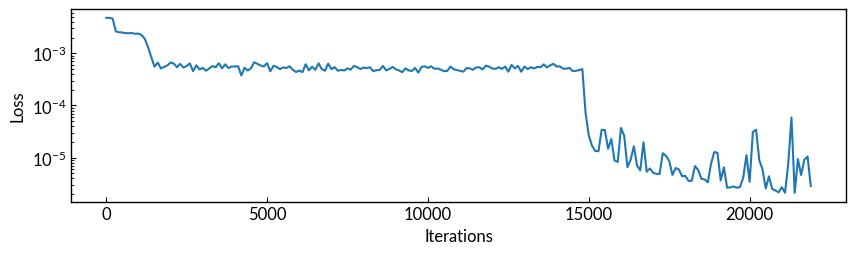

In [14]:
fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot([chkpt*k for k in range(len(loss))], loss)
ax.set_yscale('log')
format_axis(ax, props, 'Iterations', 'Loss')

In [ ]:
torch.save({
    'state': pinn.state_dict(),
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss,
    't_eval': t_eval.detach().cpu(),
    'x_eval': x_eval.detach().cpu(),
    'y_true': y_true,
    'y_pred': y_pred,
    'f_pred': f_pred,
}, model_path)

In [ ]:
# Save an animation of the training history
ani = animate_pinn_history(model_path)
ani.save('fkpp_pinn_history.gif')

### Inference

Now that we have a trained PINN, we can evaluate it at any $x$ in the domain and even beyond time points seen during training to see how it extrapolates beyond the training data.

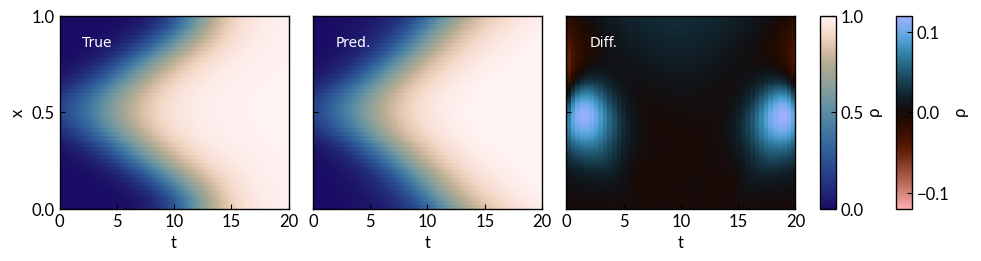

In [15]:
N = 50
L = 1.
args = {'N': N,
        'L': L,
        'r': 0.5,
        'D': 1e-3
       }
ode = FisherKPP(args, method='dopri5', default_type=default_type).to(device)

t_inf = torch.arange(0, 2*tf, dt)
x_inf = torch.arange(0, L, L/N)
    
fig = pinn_inference(ode, pinn, t_inf, x_inf, device)